In [ ]:
# default_exp mining.unsupervised.traceability.eval

# Evaluating Neural Unsupervised Approaches for Software Traceability [confirmatory analysis]

> This module is dedicated to evaluate word2vec/doc2vec or any neural unsupervised approaches on traceability datasets. Consider to Copy the entire notebook for a new and separeted empirical evaluation. 
>
> Author: @danaderp April 2020

In [ ]:
#TODO
# http://www.ashukumar27.io/similarity_functions/
# https://www.kdnuggets.com/2017/08/comparing-distance-measurements-python-scipy.html
# https://towardsdatascience.com/importance-of-distance-metrics-in-machine-learning-modelling-e51395ffe60d
# https://www.kdnuggets.com/2019/01/comparison-text-distance-metrics.html

In [ ]:
# export
# Imports
import numpy as np
import gensim
import pandas as pd
from itertools import product 
from random import sample 
import functools 
import os

In [ ]:
from datetime import datetime
import seaborn as sns

In [ ]:
#export
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from prg import prg
from pandas.plotting import scatter_matrix
from pandas.plotting import lag_plot
import math as m
import random as r
import collections
from sklearn.metrics.pairwise import cosine_similarity

ModuleNotFoundError: No module named 'prg'

In [ ]:
from gensim.models import WordEmbeddingSimilarityIndex
from gensim.similarities import SparseTermSimilarityMatrix
from gensim import corpora

In [ ]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cosine.html
from scipy.spatial import distance
from scipy.stats import pearsonr

In [ ]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [ ]:
#hide
#!pip install pyemd
!pip install pyprg
!pip install seaborn

# Artifacts Similarity with BasicSequenceVectorization

We test diferent similarities based on [blog](https://www.kdnuggets.com/2017/08/comparing-distance-measurements-python-scipy.html) and [blog2](https://www.kdnuggets.com/2019/01/comparison-text-distance-metrics.html)

In [ ]:
from enum import Enum, unique, auto

In [ ]:
@unique
class VectorizationType(Enum):
    word2vec = auto()
    doc2vec = auto()
    vsm2vec = auto()

In [ ]:
@unique
class LinkType(Enum):
    req2tc = auto()
    req2src = auto()

In [ ]:
@unique
class DistanceMetric(Enum):
    WMD = auto()
    COS = auto()
    SCM = auto()
    EUC = auto()
    MAN = auto()

In [ ]:
@unique
class SimilarityMetric(Enum):
    WMD_sim = auto()
    COS_sim = auto()
    SCM_sim = auto()
    EUC_sim = auto()
    MAN_sim = auto()
    Pearson = auto()

In [ ]:
def default_params():
    return {
        "vectorizationType": VectorizationType.word2vec,
        "linkType": LinkType.req2tc,
        "system": 'libest',
        "path_to_trained_model": 'test_data/models/word2vec_libest.model',
        "source_path": '/tf/main/benchmarking/traceability/testbeds/nltk/[libest-pre-req].csv',
        "target_path": '/tf/main/benchmarking/traceability/testbeds/nltk/[libest-pre-tc].csv',
        "system_path": '/tf/main/benchmarking/traceability/testbeds/nltk/[libest-pre-all].csv',
        "saving_path": 'test_data/',
        "names": ['Source','Target','Linked?']
    }

### Defining BasicSequenceVectorization

In [ ]:
parameters = default_params()
parameters

{'vectorizationType': <VectorizationType.word2vec: 1>,
 'linkType': <LinkType.req2tc: 1>,
 'system': 'libest',
 'path_to_trained_model': 'test_data/models/word2vec_libest.model',
 'source_path': '/tf/main/benchmarking/traceability/testbeds/nltk/[libest-pre-req].csv',
 'target_path': '/tf/main/benchmarking/traceability/testbeds/nltk/[libest-pre-tc].csv',
 'system_path': '/tf/main/benchmarking/traceability/testbeds/nltk/[libest-pre-all].csv',
 'saving_path': 'test_data/',
 'names': ['Source', 'Target', 'Linked?']}

In [ ]:
#tst
print(list(VectorizationType), list(DistanceMetric), list(SimilarityMetric), list(LinkType))

In [ ]:
#export
class BasicSequenceVectorization():
    '''Implementation of the class sequence-vanilla-vectorization other classes can inheritance this one'''
    def __init__(self, params):
                
        self.df_source = pd.read_csv(params['source_path'], names=['ids', 'text'], header=None, sep=' ')
        self.df_target = pd.read_csv(params['target_path'], names=['ids', 'text'], header=None, sep=' ')
        self.df_all_system = pd.read_csv(params['system_path'], names=['ids', 'text'], 
                                         header=0, index_col=0, sep=',')
        self.params = params
        self.df_nonground_link = None
        self.df_ground_link = None
        
        self.documents = [doc.split() for doc in self.df_all_system['text'].values] #Preparing Corpus
        self.dictionary = corpora.Dictionary( self.documents ) #Preparing Dictionary
        
        
        #This can be extended for future metrics <---------------------
        self.dict_labels = {
            DistanceMetric.COS:[DistanceMetric.COS, SimilarityMetric.COS_sim],
            SimilarityMetric.Pearson:[SimilarityMetric.Pearson],
            DistanceMetric.EUC:[DistanceMetric.EUC, SimilarityMetric.EUC_sim],
            DistanceMetric.WMD:[DistanceMetric.WMD, SimilarityMetric.WMD_sim],
            DistanceMetric.SCM:[DistanceMetric.SCM, SimilarityMetric.SCM_sim],
            DistanceMetric.MAN:[DistanceMetric.MAN, SimilarityMetric.MAN_sim]
        }

        
    def ground_truth_processing(self, path_to_ground_truth):
        'Optional class when corpus has ground truth'
        ground_truth = open(path_to_ground_truth,'r')
        #Organizing The Ground Truth under the given format
        ground_links = [ [(line.strip().split()[0], elem) for elem in line.strip().split()[1:]] for line in ground_truth]
        ground_links = functools.reduce(lambda a,b : a+b,ground_links) #reducing into one list
        assert len(ground_links) ==  len(set(ground_links)) #To Verify Redundancies in the file
        return ground_links
    
    def samplingLinks(self, sampling = False, samples = 10):
        source = [os.path.basename(elem) for elem in self.df_source['ids'].values ] 
        target = [os.path.basename(elem) for elem in self.df_target['ids'].values ]

        if sampling:
            links = sample( list( product( source , target ) ), samples)
        else:
            links = list( product( source , target ))

        return links
    
    def cos_scipy(self, vector_v, vector_w):
        cos =  distance.cosine( vector_v, vector_w )
        return [cos, 1.-cos]
    
    def euclidean_scipy(self, vector_v, vector_w):
        dst = distance.euclidean(vector_v,vector_w)
        return [dst, 1./(1.+dst)] #Computing the inverse for similarity
    
    def manhattan_scipy(self, vector_v, vector_w):
        dst = distance.cityblock(vector_v,vector_w)
        n = len(vector_v)
        return [dst, 1./(1.+dst)] #Computing the inverse for similarity
    
    def pearson_abs_scipy(self, vector_v, vector_w):
        '''We are not sure that pearson correlation works well on doc2vec inference vectors'''
        corr, _ = pearsonr(x, y)
        return [abs(corr)] #Absolute value of the correlation
    

    def computeDistanceMetric(self, links, metric_list):
        '''Metric List Iteration''' 
        
        metric_labels = [ self.dict_labels[metric] for metric in metric_list] #tracking of the labels
        distSim = [[link[0], link[1], self.distance( metric_list, link )] for link in links] #Return the link with metrics
        distSim = [[elem[0], elem[1]] + elem[2] for elem in distSim] #Return the link with metrics
        
        return distSim, functools.reduce(lambda a,b : a+b, metric_labels)
    
    def ComputeDistanceArtifacts(self, metric_list, sampling = False , samples = 10):
        '''Acticates Distance and Similarity Computations
        @metric_list if [] then Computes All metrics
        @sampling is False by the default
        @samples is the number of samples (or links) to be generated'''
        links_ = self.samplingLinks( sampling, samples )
        
        docs, metric_labels = self.computeDistanceMetric( metric_list=metric_list, links=links_) #checkpoints
        self.df_nonground_link = pd.DataFrame(docs, columns =[self.params['names'][0], self.params['names'][1]]+ metric_labels) #Transforming into a Pandas
        logging.info("Non-groundtruth links computed")
        pass 
    
    
    def SaveLinks(self, grtruth=False, sep=' ', mode='a'):
        timestamp = datetime.timestamp(datetime.now())
        path_to_link = self.params['saving_path'] + '['+ self.params['system'] + '-' + str(self.params['vectorizationType']) + '-' + str(self.params['linkType']) + '-' + str(grtruth) + '-{}].csv'.format(timestamp)
        
        if grtruth:
            self.df_ground_link.to_csv(path_to_link, header=True, index=True, sep=sep, mode=mode)
        else:
            self.df_nonground_link.to_csv(path_to_link, header=True, index=True, sep=sep, mode=mode)
        
        logging.info('Saving in...' + path_to_link)
        pass
    
    def findDistInDF(self, g_tuple):
        dist = self.df_ground_link[self.df_ground_link[self.params['names'][0]].str.contains( g_tuple[0][:g_tuple[0].find('.')] + '-' ) 
                     & self.df_ground_link[self.params['names'][1]].str.contains(g_tuple[1][:g_tuple[1].find('.')]) ]        
        return dist.index.values
        
    def MatchWithGroundTruth(self, path_to_ground_truth ):
        self.df_ground_link = self.df_nonground_link.copy()
        
        matchGT = [ self.findDistInDF( g ) for g in self.ground_truth_processing(path_to_ground_truth)]
        matchGT = functools.reduce(lambda a,b : np.concatenate([a,b]), matchGT)
        
        self.df_ground_link[self.params['names'][2]] = 0
        new_column = pd.Series(np.full([len(matchGT)], 1 ), name=self.params['names'][2], index = matchGT)
        self.df_ground_link.update(new_column)
        logging.info("Groundtruth links computed")
        
        pass

### Testing BasicSequenceVectorization

In [ ]:
general2vec =  BasicSequenceVectorization(params = parameters)

# Artifacts Similarity with Word2Vec

In [ ]:
#export
class Word2VecSeqVect(BasicSequenceVectorization):       
    
    def __init__(self, params):
        super().__init__(params)
        self.new_model = gensim.models.Word2Vec.load( params['path_to_trained_model'] )
        self.new_model.init_sims(replace=True)  # Normalizes the vectors in the word2vec class.
        #Computes cosine similarities between word embeddings and retrieves the closest 
        #word embeddings by cosine similarity for a given word embedding.
        self.similarity_index = WordEmbeddingSimilarityIndex(self.new_model.wv)
        #Build a term similarity matrix and compute the Soft Cosine Measure.
        self.similarity_matrix = SparseTermSimilarityMatrix(self.similarity_index, self.dictionary)
        
        self.dict_distance_dispatcher = {
            DistanceMetric.COS: self.cos_scipy,
            SimilarityMetric.Pearson: self.pearson_abs_scipy,
            DistanceMetric.WMD: self.wmd_gensim,
            DistanceMetric.SCM: self.scm_gensim
        }
    
    def wmd_gensim(self, sentence_a, sentence_b ):
        wmd = self.new_model.wv.wmdistance(sentence_a, sentence_b)
        return [wmd, self.wmd_similarity(wmd)]
    
    def wmd_similarity(self, dist):
        return 1./( 1.+float( dist ) ) #Associated Similarity
    
    def scm_gensim(self, sentence_a, sentence_b ):
        '''Compute SoftCosine Similarity of Gensim'''
        #Convert the sentences into bag-of-words vectors.
        sentence_1 = self.dictionary.doc2bow(sentence_a)
        sentence_2 = self.dictionary.doc2bow(sentence_b)
        
        #Return the inner product(s) between real vectors / corpora vec1 and vec2 expressed in a non-orthogonal normalized basis,
        #where the dot product between the basis vectors is given by the sparse term similarity matrix.
        scm_similarity = self.similarity_matrix.inner_product(sentence_1, sentence_2, normalized=True)
        return [1-scm_similarity, scm_similarity]
    
    def distance(self, metric_list,link):
        '''Iterate on the metrics'''
        #Computation of sentences can be moved directly to wmd_gensim method if we cannot generalize it for 
        #the remaining metrics
        sentence_a = self.df_source[self.df_source['ids'].str.contains(link[0])]['text'].values[0].split()
        sentence_b = self.df_target[self.df_target['ids'].str.contains(link[1])]['text'].values[0].split()
        
        dist = [ self.dict_distance_dispatcher[metric](sentence_a,sentence_b) for metric in metric_list]
        logging.info("Computed distances or similarities "+ str(link) + str(dist))    
        return functools.reduce(lambda a,b : a+b, dist) #Always return a list


In [ ]:
#export
def LoadLinks(timestamp, params, grtruth=False, sep=' ' ):
    '''Returns a pandas from a saved link computation at a give timestamp
    @timestamp is the version of the model for a given system'''
    
    path= params['saving_path'] + '['+ params['system'] + '-' + str(params['vectorizationType']) + '-' + str(params['linkType']) + '-' + str(grtruth) + '-{}].csv'.format(timestamp)
    
    logging.info("Loading computed links from... "+ path)

    return pd.read_csv(path, header=0, index_col=0, sep=sep)

### Testing Word2Vec SequenceVectorization

In [ ]:
#hide
#tst
metric_list = ['a','b']
A = [[1,3,4],[4,5],[1,8,9,7]]
B = ((1,3,4),(4,5),(1,8,9,7))
functools.reduce(lambda a,b : a+b, B)
dist_sim_T = [([12,13],['metric1','metric2']),([12,13],['metric1','metric2'])]
dist_sim_T
separated_merged_list_a = functools.reduce(lambda a,b : a[1]+b[1], dist_sim_T)
separated_merged_list_a

(1, 3, 4, 4, 5, 1, 8, 9, 7)

In [ ]:
#[step 1]Creating the Vectorization Class
word2vec = Word2VecSeqVect( params = parameters )

2020-06-10 20:24:45,908 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-06-10 20:24:45,965 : INFO : built Dictionary(6957 unique tokens: ['");', '"../../', '("\\', '();', ')))']...) from 87 documents (total 88944 corpus positions)
2020-06-10 20:24:45,966 : INFO : loading Word2Vec object from test_data/models/word2vec_libest.model
2020-06-10 20:24:46,013 : INFO : loading wv recursively from test_data/models/word2vec_libest.model.wv.* with mmap=None
2020-06-10 20:24:46,014 : INFO : setting ignored attribute vectors_norm to None
2020-06-10 20:24:46,015 : INFO : loading vocabulary recursively from test_data/models/word2vec_libest.model.vocabulary.* with mmap=None
2020-06-10 20:24:46,016 : INFO : loading trainables recursively from test_data/models/word2vec_libest.model.trainables.* with mmap=None
2020-06-10 20:24:46,017 : INFO : setting ignored attribute cum_table to None
2020-06-10 20:24:46,018 : INFO : loaded test_data/models/word2vec_libest.model
2020-06-10 20:24:46,

In [ ]:
word2vec.df_source['ids'][0]

'test_data/LibEST_semeru_format/requirements/RQ17-pre.txt'

In [ ]:
idss = word2vec.df_source['ids'][0] #Selecting an ID
idss = word2vec.df_source['ids'] == idss #Search for an specific ID
list(word2vec.df_source[idss]['text'])[0].split() #Retrieving text and splitting

['requir',
 'http',
 'uri',
 'control',
 'est',
 'server',
 'must',
 'support',
 'use',
 'path',
 'prefix',
 'well',
 'known',
 'defin',
 'rfc',
 'regist',
 'name',
 'est',
 'thus',
 'valid',
 'est',
 'server',
 'uri',
 'path',
 'begin',
 'https',
 'www',
 'exampl',
 'com',
 'well',
 'known',
 'est',
 'est',
 'oper',
 'indic',
 'path',
 'suffix',
 'indic',
 'intend',
 'oper',
 'oper',
 'correspond',
 'uri',
 'oper',
 'oper',
 'path',
 'detail',
 'distribut',
 'cacert',
 'section',
 'certif',
 'must',
 'enrol',
 'simpleenrol',
 'section',
 'client',
 'must',
 'enrol',
 'simplereenrol',
 'section',
 'client',
 'must',
 'full',
 'cmc',
 'option',
 'fullcmc',
 'section',
 'server',
 'side',
 'key',
 'serverkeygen',
 'section',
 'generat',
 'option',
 'csr',
 'attribut',
 'csrattr',
 'section',
 'option',
 'figur',
 'oper',
 'path',
 'figur',
 'append',
 'path',
 'prefix',
 'form',
 'uri',
 'use',
 'http',
 'get',
 'post',
 'perform',
 'desir',
 'est',
 'oper',
 'exampl',
 'valid',
 'uri',


In [ ]:
word2vec.df_source.head()

,ids,text
0,test_data/LibEST_semeru_format/requirements/RQ...,requir http uri control est server must suppor...
1,test_data/LibEST_semeru_format/requirements/RQ...,requir server side key generat respons request...
2,test_data/LibEST_semeru_format/requirements/RQ...,requir http base client authent est server may...
3,test_data/LibEST_semeru_format/requirements/RQ...,requir csr attribut request est client request...
4,test_data/LibEST_semeru_format/requirements/RQ...,requir server side key generat est client may ...


In [ ]:
word2vec.df_target.head()

,ids,text
0,test_data/LibEST_semeru_format/test/us903.c,unit test user stori server simpl enrol august...
1,test_data/LibEST_semeru_format/test/us3496.c,unit test uri path segment extens support marc...
2,test_data/LibEST_semeru_format/test/us899.c,unit test user stori client simpl enrol septem...
3,test_data/LibEST_semeru_format/test/us4020.c,unit test user stori unit test client proxi mo...
4,test_data/LibEST_semeru_format/test/us897.c,unit test user stori client cacert june copyri...


In [ ]:
links = word2vec.samplingLinks(sampling=True, samples = 2)
links

[('RQ15-pre.txt', 'us2174.c'), ('RQ13-pre.txt', 'us899.c')]

In [ ]:
print( len(links), word2vec.df_source.shape, word2vec.df_target.shape )

2 (52, 2) (21, 2)


In [ ]:
#[optional] computeDistanceMetric Testing [WARNING!] Time Consuming!!
computeDistanceMetric = word2vec.computeDistanceMetric(links, metric_list = [DistanceMetric.WMD,DistanceMetric.SCM])
computeDistanceMetric

2020-06-10 17:56:41,219 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-06-10 17:56:41,224 : INFO : built Dictionary(1142 unique tokens: ['addit', 'also', 'associ', 'authent', 'avail']...) from 2 documents (total 2543 corpus positions)
2020-06-10 17:56:49,231 : INFO : Computed distances or similarities ('RQ15-pre.txt', 'us2174.c')[[0.3589300961999218, 0.7358730245186085], [0.5082340836524963, 0.49176592]]
2020-06-10 17:56:49,235 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-06-10 17:56:49,240 : INFO : built Dictionary(778 unique tokens: ['1ar', '802', 'also', 'anchor', 'aspect']...) from 2 documents (total 3979 corpus positions)
2020-06-10 17:57:00,823 : INFO : Computed distances or similarities ('RQ13-pre.txt', 'us899.c')[[0.34410217762685374, 0.7439910571126367], [0.46100157499313354, 0.5389984]]


([['RQ15-pre.txt',
   'us2174.c',
   0.3589300961999218,
   0.7358730245186085,
   0.5082340836524963,
   0.49176592],
  ['RQ13-pre.txt',
   'us899.c',
   0.34410217762685374,
   0.7439910571126367,
   0.46100157499313354,
   0.5389984]],
 [<DistanceMetric.WMD: 1>,
  <SimilarityMetric.WMD_sim: 1>,
  <DistanceMetric.SCM: 3>,
  <SimilarityMetric.SCM_sim: 3>])

In [ ]:
#[step 2]NonGroundTruth Computation
word2vec.ComputeDistanceArtifacts( sampling=True, samples = 50, metric_list = [DistanceMetric.WMD,DistanceMetric.SCM] )
word2vec.df_nonground_link.head()

2020-06-10 18:00:03,762 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-06-10 18:00:03,766 : INFO : built Dictionary(431 unique tokens: ['authent', 'certif', 'cipher', 'client', 'est']...) from 2 documents (total 2691 corpus positions)
2020-06-10 18:00:04,002 : INFO : Computed distances or similarities ('RQ7-pre.txt', 'us900.c')[[0.6801433900455611, 0.5951872952777457], [0.9215486720204353, 0.07845133]]
2020-06-10 18:00:04,008 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-06-10 18:00:04,014 : INFO : built Dictionary(881 unique tokens: ['0ue', '1958a6m9o', '1o9q', '4mgv', '4o38fup0en']...) from 2 documents (total 1763 corpus positions)
2020-06-10 18:00:28,826 : INFO : Computed distances or similarities ('RQ58-pre.txt', 'us3612.c')[[0.41518281434799253, 0.7066224871171313], [0.7362554371356964, 0.26374456]]
2020-06-10 18:00:28,830 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-06-10 18:00:28,832 : INFO : built Dictionary(516 

2020-06-10 18:02:15,677 : INFO : built Dictionary(444 unique tokens: ['addit', 'algorithm', 'appli', 'archiv', 'associ']...) from 2 documents (total 2306 corpus positions)
2020-06-10 18:02:16,886 : INFO : Computed distances or similarities ('RQ42-pre.txt', 'us1159.c')[[0.4569413668285707, 0.6863694193657032], [0.6258775889873505, 0.3741224]]
2020-06-10 18:02:16,889 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-06-10 18:02:16,891 : INFO : built Dictionary(398 unique tokens: ['certif', 'client', 'cmc', 'est', 'full']...) from 2 documents (total 2671 corpus positions)
2020-06-10 18:02:17,118 : INFO : Computed distances or similarities ('RQ39-pre.txt', 'us898.c')[[0.5108613213361184, 0.6618741150350304], [0.7524681985378265, 0.2475318]]
2020-06-10 18:02:17,121 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-06-10 18:02:17,123 : INFO : built Dictionary(317 unique tokens: ['authent', 'author', 'base', 'cacert', 'certif']...) from 2 documents (total 1

2020-06-10 18:05:25,611 : INFO : Computed distances or similarities ('RQ27-pre.txt', 'us897.c')[[0.5015991374187515, 0.6659566958189651], [0.6960231959819794, 0.3039768]]
2020-06-10 18:05:25,615 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-06-10 18:05:25,619 : INFO : built Dictionary(1146 unique tokens: ['applic', 'base', 'binari', 'bodi', 'cmc']...) from 2 documents (total 2979 corpus positions)
2020-06-10 18:05:29,518 : INFO : Computed distances or similarities ('RQ40-pre.txt', 'us1883.c')[[0.3118055184341965, 0.762308121095286], [0.5388751924037933, 0.4611248]]
2020-06-10 18:05:29,521 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-06-10 18:05:29,523 : INFO : built Dictionary(638 unique tokens: ['applic', 'attribut', 'cacert', 'certif', 'client']...) from 2 documents (total 1155 corpus positions)
2020-06-10 18:05:31,941 : INFO : Computed distances or similarities ('RQ19-pre.txt', 'us1864.c')[[0.3231855315912456, 0.7557519154531663], [0.6546

,Source,Target,DistanceMetric.WMD,SimilarityMetric.WMD_sim,DistanceMetric.SCM,SimilarityMetric.SCM_sim
0,RQ7-pre.txt,us900.c,0.680143,0.595187,0.921549,0.078451
1,RQ58-pre.txt,us3612.c,0.415183,0.706622,0.736255,0.263745
2,RQ48-pre.txt,us893.c,0.354683,0.738180,0.352155,0.647845
3,RQ58-pre.txt,us1060.c,0.258274,0.794739,0.631336,0.368664
4,RQ23-pre.txt,us1005.c,0.359392,0.735623,0.369689,0.630311


In [ ]:
#[step 3]Saving Non-GroundTruth Links
word2vec.SaveLinks()

2020-06-10 18:08:20,555 : INFO : Saving in...test_data/[libest-VectorizationType.word2vec-LinkType.req2tc-False-1591812500.551167].csv


In [ ]:
#Loading Non-GroundTruth Links (change the timestamp with the assigned in the previous step)
df_nonglinks = LoadLinks(timestamp=1591812500.551167, params=parameters)
df_nonglinks.head()

2020-06-10 18:08:48,927 : INFO : Loading computed links from... test_data/[libest-VectorizationType.word2vec-LinkType.req2tc-False-1591812500.551167].csv


,Source,Target,DistanceMetric.WMD,SimilarityMetric.WMD_sim,DistanceMetric.SCM,SimilarityMetric.SCM_sim
0,RQ7-pre.txt,us900.c,0.680143,0.595187,0.921549,0.078451
1,RQ58-pre.txt,us3612.c,0.415183,0.706622,0.736255,0.263745
2,RQ48-pre.txt,us893.c,0.354683,0.738180,0.352155,0.647845
3,RQ58-pre.txt,us1060.c,0.258274,0.794739,0.631336,0.368664
4,RQ23-pre.txt,us1005.c,0.359392,0.735623,0.369689,0.630311


In [ ]:
#[step 4]GroundTruthMatching Testing
path_to_ground_truth = '/tf/main/benchmarking/traceability/testbeds/groundtruth/english/[libest-ground-req-to-tc].txt'
word2vec.MatchWithGroundTruth(path_to_ground_truth)
word2vec.df_ground_link

2020-06-10 18:08:54,535 : INFO : Groundtruth links computed


,Source,Target,DistanceMetric.WMD,SimilarityMetric.WMD_sim,DistanceMetric.SCM,SimilarityMetric.SCM_sim,Linked?
0,RQ7-pre.txt,us900.c,0.680143,0.595187,0.921549,0.078451,0.0
1,RQ58-pre.txt,us3612.c,0.415183,0.706622,0.736255,0.263745,0.0
2,RQ48-pre.txt,us893.c,0.354683,0.738180,0.352155,0.647845,1.0
3,RQ58-pre.txt,us1060.c,0.258274,0.794739,0.631336,0.368664,0.0
4,RQ23-pre.txt,us1005.c,0.359392,0.735623,0.369689,0.630311,1.0
5,RQ22-pre.txt,us897.c,0.535448,0.651276,0.709897,0.290103,1.0
6,RQ24-pre.txt,us1159.c,0.441503,0.693721,0.694179,0.305821,1.0
7,RQ1-pre.txt,us903.c,0.318199,0.758611,0.497516,0.502484,0.0
8,RQ9-pre.txt,us4020.c,0.547493,0.646207,0.744325,0.255675,0.0
9,RQ48-pre.txt,us4020.c,0.460795,0.684559,0.620370,0.379630,0.0


In [ ]:
#[optional]GroundTruth Direct Processing
ground_links = word2vec.ground_truth_processing(path_to_ground_truth)
ground_links[141] # A tuple

('RQ33.txt', 'us894.c')

In [ ]:
#Inspecting Source
ground_links[141][0][:ground_links[141][0].find('.')] + '-'

'RQ33-'

In [ ]:
#Inspecting Target
ground_links[141][1][:ground_links[141][1].find('.')]

'us894'

In [ ]:
#[step 5]Saving GroundTruth Links
word2vec.SaveLinks(grtruth = True)

2020-06-09 19:12:16,394 : INFO : Saving in...test_data/[libest-VectorizationType.word2vec-LinkType.req2tc-True-1591729936.391725].csv


In [ ]:
#Loading Non-GroundTruth Links (change the timestamp with the assigned in the previous step)
df_glinks = LoadLinks(timestamp=1591729936.391725, params=parameters,grtruth = True)
df_glinks.head()

2020-06-09 19:12:26,547 : INFO : Loading computed links from... test_data/[libest-VectorizationType.word2vec-LinkType.req2tc-True-1591729936.391725].csv


,Source,Target,DistanceMetric.WMD,SimilarityMetric.WMD_sim,Linked?
0,RQ11-pre.txt,us4020.c,0.498776,0.667211,1
1,RQ51-pre.txt,us4020.c,0.418114,0.705162,1


# Approach Evaluation and Interpretation (word2vec)
Classification/evaluation metrics for highly imbalanced data [(see Forum)](https://stats.stackexchange.com/questions/222558/classification-evaluation-metrics-for-highly-imbalanced-data).

In [ ]:
#export
class VectorEvaluation():
    '''Approaches Common Evaluations and Interpretations (statistical analysis)'''
    def __init__(self, sequenceVectorization):
        self.seqVect = sequenceVectorization

In [ ]:
#export
class SupervisedVectorEvaluation(VectorEvaluation):
    def __init__(self, sequenceVectorization, similarity):
        super().__init__(sequenceVectorization)
        self.y_test = sequenceVectorization.df_ground_link['Linked?'].values
        self.y_score = sequenceVectorization.df_ground_link[similarity].values
        self.label = str(sequenceVectorization.params['vectorizationType'])+'-'+str(similarity)
        pass
    
    def Compute_precision_recall_gain(self):
        '''One might choose PRG if there is little interest in identifying false negatives '''
        prg_curve = prg.create_prg_curve(self.y_test, self.y_score)
        auprg = prg.calc_auprg(prg_curve)
        prg.plot_prg(prg_curve)
        logging.info('auprg:  %.3f' %  auprg)
        logging.info("compute_precision_recall_gain Complete")
        pass
    
    def Compute_avg_precision(self):
        '''Generated precision-recall curve'''
        %matplotlib inline
        # calculate the no skill line as the proportion of the positive class
        no_skill = len(self.y_test[self.y_test==1]) / len(self.y_test)
        plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill') #reference curve
        precision, recall, _ = precision_recall_curve(self.y_test, self.y_score) #compute precision-recall curve
        plt.plot(recall, precision, marker='.', label = self.label) #plot model curve
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend() #show the legend
        plt.show() #show the plot

        average_precision = average_precision_score(self.y_test, self.y_score)
        auc_score = auc(recall, precision)
        logging.info('Average precision-recall score: {0:0.2f}'.format(average_precision))
        logging.info('Precision-Recall AUC: %.3f' % auc_score)
        #logging.info("compute_precision_recall_gain Complete")
        pass
    
    def Compute_roc_curve(self):
        %matplotlib inline
        plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill') #reference curve
        fpr, tpr, _ = roc_curve(self.y_test, self.y_score) #compute roc curve
        plt.plot(fpr, tpr, marker='.', label=self.label) #plot model curve
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend() #show the legend
        plt.show() #show the plot

        roc_auc = roc_auc_score(self.y_test, self.y_score)
        logging.info('ROC AUC %.3f' % roc_auc)

        pass

In [ ]:
supevisedEval = SupervisedVectorEvaluation(word2vec, similarity=SimilarityMetric.SCM_sim)

In [ ]:
supevisedEval.y_test

array([0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0.])

In [ ]:
supevisedEval.y_score

array([0.07845133, 0.26374456, 0.64784521, 0.36866382, 0.63031077,
       0.29010326, 0.3058207 , 0.50248373, 0.25567511, 0.37962961,
       0.5055787 , 0.48356244, 0.38084632, 0.53910714, 0.3022235 ,
       0.33587378, 0.23171991, 0.30130732, 0.26407   , 0.37412241,
       0.2475318 , 0.49549639, 0.54670042, 0.53197539, 0.12659086,
       0.25125319, 0.31500998, 0.50762564, 0.52043569, 0.07250119,
       0.63482744, 0.28554901, 0.30319259, 0.49079701, 0.25948158,
       0.34315839, 0.47885129, 0.2508772 , 0.3039768 , 0.46112481,
       0.34535933, 0.48701519, 0.37489104, 0.46595106, 0.33792901,
       0.49650738, 0.49440292, 0.4971208 , 0.19068524, 0.30360138])

## Confusion Matrix

In [ ]:
y_score_threshold = [0 if elem<=0.8 else 1 for elem in supevisedEval.y_score] #Hardcoded 0.7 Threshold

In [ ]:
#TODO a Variation threshold analysis
tn, fp, fn, tp = confusion_matrix(supevisedEval.y_test, y_score_threshold).ravel()

In [ ]:
(tn, fp, fn, tp)

(35, 0, 15, 0)

## Precision-Racall-Gain
Based on the library here: [link](https://github.com/meeliskull/prg/tree/master/Python_package). 
The area under traditional PR curves can easily favour models with lower expected F1 score than others, and so the use of Precision-Recall-Gain curves will result in better model selection [(Flach & Kull, 2015)](http://people.cs.bris.ac.uk/~flach//PRGcurves/).
One might choose PRG if there is little interest in identifying false negatives [(from Blog)](https://medium.com/@alexabate/i-did-something-boring-so-you-dont-have-to-9140ca46c84d).

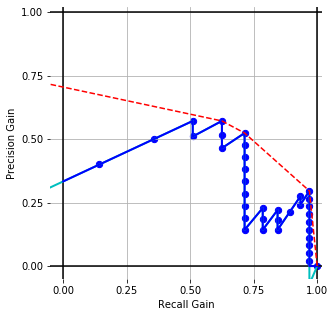

2020-06-10 18:10:32,860 : INFO : auprg:  0.388
2020-06-10 18:10:32,861 : INFO : compute_precision_recall_gain Complete


In [ ]:
supevisedEval.Compute_precision_recall_gain()

## Compute the average precision score¶
Precision is a metric that quantifies the number of correct positive predictions made.

Recall is a metric that quantifies the number of correct positive predictions made out of all positive predictions that could have been made.

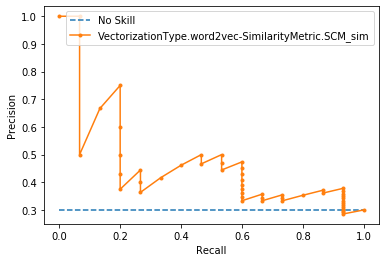

2020-06-10 18:10:36,207 : INFO : Average precision-recall score: 0.49
2020-06-10 18:10:36,208 : INFO : Precision-Recall AUC: 0.467


In [ ]:
supevisedEval.Compute_avg_precision()

## Compute ROC Curve
An ROC curve (or receiver operating characteristic curve) is a plot that summarizes the performance of a binary classification model on the positive class [(see Blog)](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/).

Use ROC when both classes detection is equally important — When we want to give equal weight to both classes prediction ability we should look at the ROC curve [link](https://towardsdatascience.com/what-metrics-should-we-use-on-imbalanced-data-set-precision-recall-roc-e2e79252aeba).

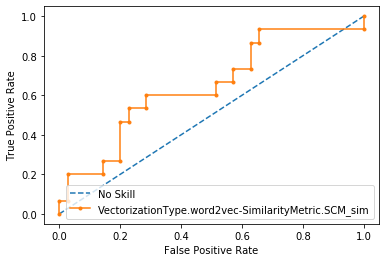

2020-06-10 18:10:58,501 : INFO : ROC AUC 0.646


In [ ]:
supevisedEval.Compute_roc_curve()

## Compute distribution of similarities word2vec

In [ ]:
#Basic Statistics
filter_metrics = word2vec.df_ground_link
filter_metrics.describe()

,DistanceMetric.WMD,SimilarityMetric.WMD_sim,DistanceMetric.SCM,SimilarityMetric.SCM_sim,Linked?
count,50.000000,50.000000,50.000000,50.000000,50.00000
mean,0.419498,0.707771,0.622769,0.377231,0.30000
std,0.099211,0.048308,0.137919,0.137919,0.46291
min,0.258274,0.591856,0.352155,0.072501,0.00000
25%,0.346206,0.668224,0.504777,0.286688,0.00000
50%,0.432050,0.698306,0.642988,0.357012,0.00000
75%,0.496556,0.742834,0.713312,0.495223,1.00000
max,0.689601,0.794739,0.927499,0.647845,1.00000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f33ce5a46d8>,
      dtype=object)

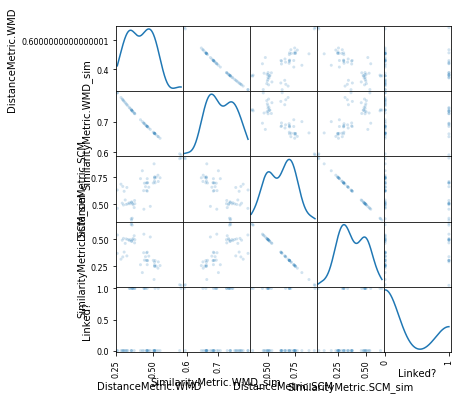

In [ ]:
scatter_matrix(filter_metrics, alpha=0.2, figsize=(6, 6), diagonal='kde')

Lag plots are used to check if a data set or time series is random. Random data should not exhibit any structure in the lag plot. Non-random structure implies that the underlying data are not random. The lag argument may be passed, and when lag=1 the plot is essentially data[:-1] vs. data[1:].

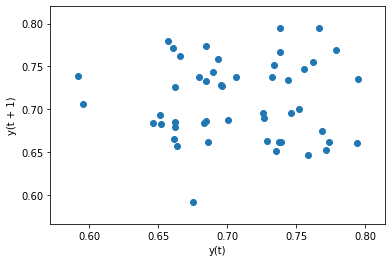

In [ ]:
lag_plot(filter_metrics[[SimilarityMetric.WMD_sim]])

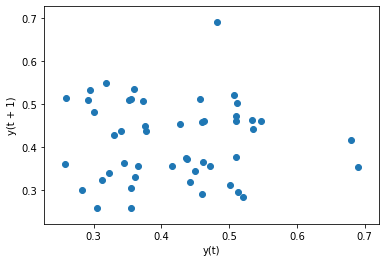

In [ ]:
lag_plot(filter_metrics[DistanceMetric.WMD])

In [ ]:
# calculate model precision-recall curve
sim = np.array(filter_metrics[SimilarityMetric.WMD_sim])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f33c9cdc240>,
      dtype=object)

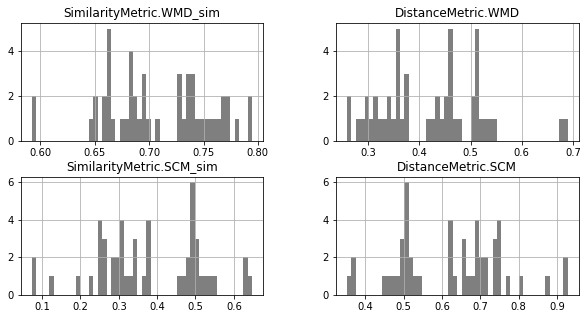

In [ ]:
filter_metrics.hist(column=[SimilarityMetric.WMD_sim,DistanceMetric.WMD,SimilarityMetric.SCM_sim,
                            DistanceMetric.SCM],color='k',bins=50,figsize=[10,5],alpha=0.5)

SimilarityMetric.WMD_sim    0.048308
DistanceMetric.WMD          0.099211
SimilarityMetric.SCM_sim    0.137919
DistanceMetric.SCM          0.137919
dtype: float64


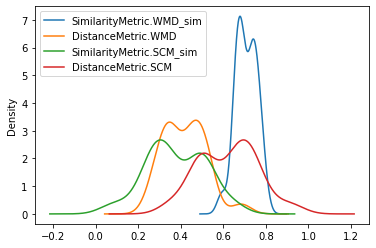

In [ ]:
errors = filter_metrics[[SimilarityMetric.WMD_sim,DistanceMetric.WMD,SimilarityMetric.SCM_sim,
                            DistanceMetric.SCM]].std()
print(errors)
filter_metrics[[SimilarityMetric.WMD_sim,DistanceMetric.WMD,SimilarityMetric.SCM_sim,
                            DistanceMetric.SCM]].plot.kde()

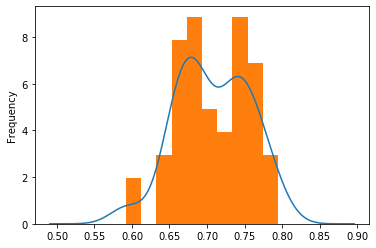

In [ ]:
filter_metrics[SimilarityMetric.WMD_sim].plot.kde()
filter_metrics[SimilarityMetric.WMD_sim].plot.hist(density=True) # Histogram will now be normalized

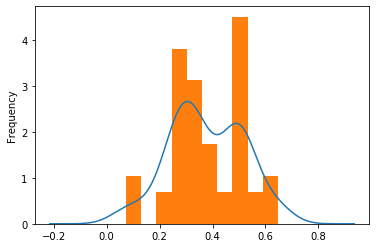

In [ ]:
filter_metrics[SimilarityMetric.SCM_sim].plot.kde()
filter_metrics[SimilarityMetric.SCM_sim].plot.hist(density=True) # Histogram will now be normalized

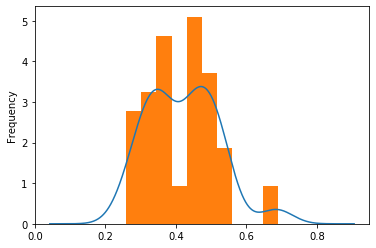

In [ ]:
filter_metrics[DistanceMetric.WMD].plot.kde()
filter_metrics[DistanceMetric.WMD].plot.hist(density=True)

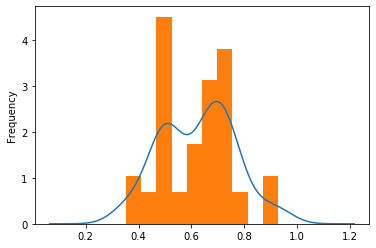

In [ ]:
filter_metrics[DistanceMetric.SCM].plot.kde()
filter_metrics[DistanceMetric.SCM].plot.hist(density=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f33c70c9d30>,
      dtype=object)

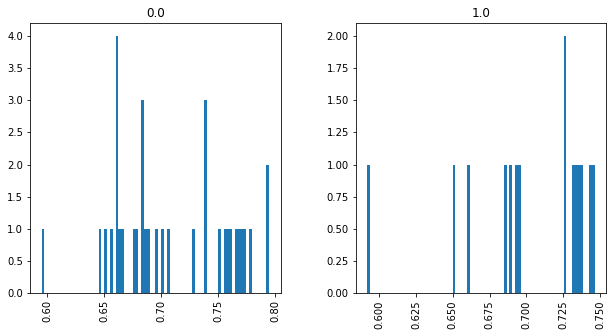

In [ ]:
filter_metrics.hist(by='Linked?',column=SimilarityMetric.WMD_sim ,figsize=[10, 5],bins=80)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f33ca0c6080>,
      dtype=object)

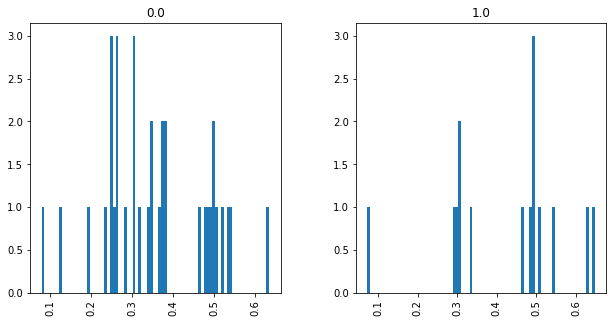

In [ ]:
filter_metrics.hist(by='Linked?',column=SimilarityMetric.SCM_sim ,figsize=[10, 5],bins=80)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f33ca4218d0>,
      dtype=object)

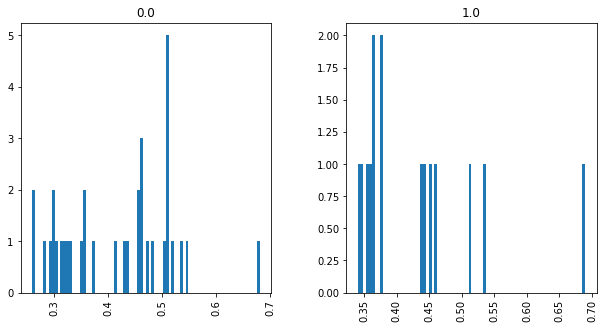

In [ ]:
filter_metrics.hist(by='Linked?',column=DistanceMetric.WMD,figsize=[10, 5],bins=80)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f33ca19d908>,
      dtype=object)

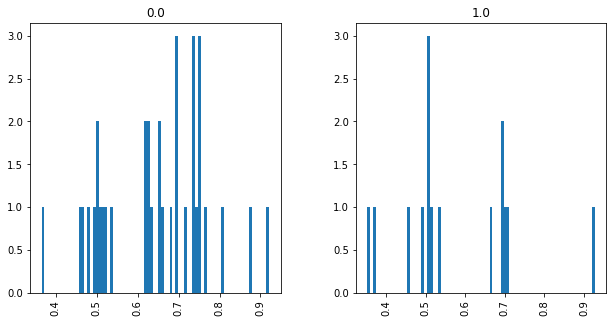

In [ ]:
filter_metrics.hist(by='Linked?',column=DistanceMetric.SCM,figsize=[10, 5],bins=80)

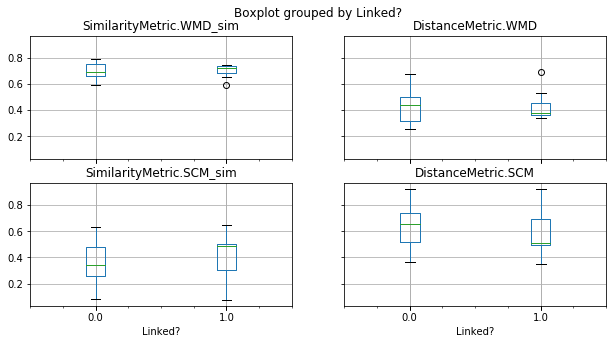

In [ ]:
boxplot = filter_metrics.boxplot(by='Linked?',column=[SimilarityMetric.WMD_sim,DistanceMetric.WMD,SimilarityMetric.SCM_sim,
                            DistanceMetric.SCM],figsize=[10, 5])

# Artifacts Similarity with Doc2Vec

Try to reproduce the same empirical evaluation like here: [link](https://arxiv.org/pdf/1507.07998.pdf). Pay attention to:
- Accuracy vs. Dimensionality (we can replace accuracy for false positive rate or true positive rate)
- Visualize paragraph vectors using t-sne
- Computing Cosine Distance and Similarity. More about similarity [link](https://www.kdnuggets.com/2017/08/comparing-distance-measurements-python-scipy.html)

In [ ]:
def doc2vec_params():
    return {
        "vectorizationType": VectorizationType.doc2vec,
        "linkType": LinkType.req2tc,
        "system": 'libest',
        "path_to_trained_model": 'test_data/models/doc2vec_libest.model',
        "source_path": '/tf/main/benchmarking/traceability/testbeds/nltk/[libest-pre-req].csv',
        "target_path": '/tf/main/benchmarking/traceability/testbeds/nltk/[libest-pre-tc].csv',
        "system_path": '/tf/main/benchmarking/traceability/testbeds/nltk/[libest-pre-all].csv',
        "saving_path": 'test_data/',
        "names": ['Source','Target','Linked?']
    }

In [ ]:
doc2vec_params = doc2vec_params()
doc2vec_params

{'vectorizationType': <VectorizationType.doc2vec: 2>,
 'linkType': <LinkType.req2tc: 1>,
 'system': 'libest',
 'path_to_trained_model': 'test_data/models/doc2vec_libest.model',
 'source_path': '/tf/main/benchmarking/traceability/testbeds/nltk/[libest-pre-req].csv',
 'target_path': '/tf/main/benchmarking/traceability/testbeds/nltk/[libest-pre-tc].csv',
 'system_path': '/tf/main/benchmarking/traceability/testbeds/nltk/[libest-pre-all].csv',
 'saving_path': 'test_data/',
 'names': ['Source', 'Target', 'Linked?']}

In [ ]:
#Export
class Doc2VecSeqVect(BasicSequenceVectorization):
    
    def __init__(self, params):
        super().__init__(params)
        self.new_model = gensim.models.Doc2Vec.load( params['path_to_trained_model'] )
        self.new_model.init_sims(replace=True)  # Normalizes the vectors in the word2vec class.
        self.df_inferred_src = None
        self.df_inferred_trg = None
        
        self.dict_distance_dispatcher = {
            DistanceMetric.COS: self.cos_scipy,
            SimilarityMetric.Pearson: self.pearson_abs_scipy,
            DistanceMetric.EUC: self.euclidean_scipy,
            DistanceMetric.MAN: self.manhattan_scipy
        }
    
    def distance(self, metric_list, link):
        '''Iterate on the metrics'''
        ν_inferredSource = list(self.df_inferred_src[self.df_inferred_src['ids'].str.contains(link[0])]['inf-doc2vec'])
        w_inferredTarget = list(self.df_inferred_trg[self.df_inferred_trg['ids'].str.contains(link[1])]['inf-doc2vec'])
        
        dist = [ self.dict_distance_dispatcher[metric](ν_inferredSource,w_inferredTarget) for metric in metric_list]
        logging.info("Computed distances or similarities "+ str(link) + str(dist))    
        return functools.reduce(lambda a,b : a+b, dist) #Always return a list
    
    def computeDistanceMetric(self, links, metric_list):
        '''It is computed the cosine similarity'''
        
        metric_labels = [ self.dict_labels[metric] for metric in metric_list] #tracking of the labels
        distSim = [[link[0], link[1], self.distance( metric_list, link )] for link in links] #Return the link with metrics
        distSim = [[elem[0], elem[1]] + elem[2] for elem in distSim] #Return the link with metrics
        
        return distSim, functools.reduce(lambda a,b : a+b, metric_labels)

    
    def InferDoc2Vec(self, steps=200):
        '''Activate Inference on Target and Source Corpus'''
        self.df_inferred_src = self.df_source.copy()
        self.df_inferred_trg = self.df_target.copy()
        
        self.df_inferred_src['inf-doc2vec'] =  [self.new_model.infer_vector(artifact.split(),steps=steps) for artifact in self.df_inferred_src['text'].values]
        self.df_inferred_trg['inf-doc2vec'] =  [self.new_model.infer_vector(artifact.split(),steps=steps) for artifact in self.df_inferred_trg['text'].values]
        
        logging.info("Infer Doc2Vec on Source and Target Complete")
    

### Testing Doc2Vec SequenceVectorization

In [ ]:
doc2vec = Doc2VecSeqVect(params = doc2vec_params)

2020-06-10 20:49:50,739 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-06-10 20:49:50,797 : INFO : built Dictionary(6957 unique tokens: ['");', '"../../', '("\\', '();', ')))']...) from 87 documents (total 88944 corpus positions)
2020-06-10 20:49:50,799 : INFO : loading Doc2Vec object from test_data/models/doc2vec_libest.model
2020-06-10 20:49:50,818 : INFO : loading vocabulary recursively from test_data/models/doc2vec_libest.model.vocabulary.* with mmap=None
2020-06-10 20:49:50,819 : INFO : loading trainables recursively from test_data/models/doc2vec_libest.model.trainables.* with mmap=None
2020-06-10 20:49:50,820 : INFO : loading wv recursively from test_data/models/doc2vec_libest.model.wv.* with mmap=None
2020-06-10 20:49:50,821 : INFO : loading docvecs recursively from test_data/models/doc2vec_libest.model.docvecs.* with mmap=None
2020-06-10 20:49:50,823 : INFO : loaded test_data/models/doc2vec_libest.model
2020-06-10 20:49:50,838 : INFO : precomputing L2-norms

In [ ]:
#[step1]Apply Doc2Vec Inference
doc2vec.InferDoc2Vec(steps=200)

2020-06-10 20:50:02,224 : INFO : Infer Doc2Vec on Source and Target Complete


In [ ]:
doc2vec.df_inferred_src.head(2)

,ids,text,inf-doc2vec
0,test_data/LibEST_semeru_format/requirements/RQ...,requir http uri control est server must suppor...,"[-2.831539, -2.4195707, -6.47853, 3.0078099, -..."
1,test_data/LibEST_semeru_format/requirements/RQ...,requir server side key generat respons request...,"[-3.5905514, -2.1303558, -6.4233136, 1.1223232..."


In [ ]:
#test_inferDoc2Vec_trg = inferDoc2Vec(df_target)
#test_inferDoc2Vec_trg.head()
doc2vec.df_inferred_trg.head(2)

,ids,text,inf-doc2vec
0,test_data/LibEST_semeru_format/test/us903.c,unit test user stori server simpl enrol august...,"[-1.1435399, -0.6798092, -3.854059, -6.446299,..."
1,test_data/LibEST_semeru_format/test/us3496.c,unit test uri path segment extens support marc...,"[-7.902068, -3.1715784, -2.0337794, 0.39057884..."


In [ ]:
#[step 2]NonGroundTruth Computation
doc2vec.ComputeDistanceArtifacts( sampling=True, samples = 50, metric_list = [DistanceMetric.EUC] )
doc2vec.df_nonground_link.head()

2020-06-10 20:52:14,408 : INFO : Computed distances or similarities ('RQ34-pre.txt', 'us901.c')[[34.769779205322266, 0.027956560599938167]]
2020-06-10 20:52:14,413 : INFO : Computed distances or similarities ('RQ25-pre.txt', 'us2174.c')[[44.54707336425781, 0.021955307468442764]]
2020-06-10 20:52:14,418 : INFO : Computed distances or similarities ('RQ26-pre.txt', 'us4020.c')[[27.537466049194336, 0.035041653602886434]]
2020-06-10 20:52:14,422 : INFO : Computed distances or similarities ('RQ6-pre.txt', 'us3612.c')[[27.061159133911133, 0.03563644663528984]]
2020-06-10 20:52:14,427 : INFO : Computed distances or similarities ('RQ32-pre.txt', 'us894.c')[[34.56857681274414, 0.028114703752827756]]
2020-06-10 20:52:14,429 : INFO : Computed distances or similarities ('RQ6-pre.txt', 'us1864.c')[[33.20020294189453, 0.029239592574903144]]
2020-06-10 20:52:14,432 : INFO : Computed distances or similarities ('RQ26-pre.txt', 'us3496.c')[[34.45558166503906, 0.028204303893455764]]
2020-06-10 20:52:14,43

,Source,Target,DistanceMetric.EUC,SimilarityMetric.EUC_sim
0,RQ34-pre.txt,us901.c,34.769779,0.027957
1,RQ25-pre.txt,us2174.c,44.547073,0.021955
2,RQ26-pre.txt,us4020.c,27.537466,0.035042
3,RQ6-pre.txt,us3612.c,27.061159,0.035636
4,RQ32-pre.txt,us894.c,34.568577,0.028115


In [ ]:
#[step 3]Saving Non-GroundTruth Links
doc2vec.SaveLinks()

2020-06-10 19:18:35,270 : INFO : Saving in...test_data/[libest-VectorizationType.doc2vec-LinkType.req2tc-False-1591816715.266613].csv


In [ ]:
#Loading Non-GroundTruth Links (change the timestamp with the assigned in the previous step)
df_nonglinks_doc2vec = LoadLinks(timestamp=1591816715.266613, params=doc2vec_params)
df_nonglinks_doc2vec.head()

2020-06-10 19:18:49,355 : INFO : Loading computed links from... test_data/[libest-VectorizationType.doc2vec-LinkType.req2tc-False-1591816715.266613].csv


,Source,Target,DistanceMetric.COS,SimilarityMetric.COS_sim
0,RQ10-pre.txt,us1864.c,0.555511,0.444489
1,RQ26-pre.txt,us894.c,0.641956,0.358044
2,RQ45-pre.txt,us3612.c,0.605190,0.394810
3,RQ38-pre.txt,us4020.c,0.774346,0.225654
4,RQ42-pre.txt,us2174.c,0.702200,0.297800


In [ ]:
#[step 4]GroundTruthMatching Testing
path_to_ground_truth = '/tf/main/benchmarking/traceability/testbeds/groundtruth/english/[libest-ground-req-to-tc].txt'
doc2vec.MatchWithGroundTruth(path_to_ground_truth)
doc2vec.df_ground_link

2020-06-10 20:59:11,604 : INFO : Groundtruth links computed


,Source,Target,DistanceMetric.EUC,SimilarityMetric.EUC_sim,Linked?
0,RQ34-pre.txt,us901.c,34.769779,0.027957,1.0
1,RQ25-pre.txt,us2174.c,44.547073,0.021955,0.0
2,RQ26-pre.txt,us4020.c,27.537466,0.035042,1.0
3,RQ6-pre.txt,us3612.c,27.061159,0.035636,1.0
4,RQ32-pre.txt,us894.c,34.568577,0.028115,0.0
5,RQ6-pre.txt,us1864.c,33.200203,0.029240,0.0
6,RQ26-pre.txt,us3496.c,34.455582,0.028204,1.0
7,RQ4-pre.txt,us1159.c,33.715126,0.028806,0.0
8,RQ2-pre.txt,us1159.c,28.305454,0.034123,0.0
9,RQ34-pre.txt,us1864.c,38.042309,0.025613,1.0


In [ ]:
#[step 5]Saving GroundTruth Links
doc2vec.SaveLinks(grtruth = True)

2020-06-04 02:59:09,162 : INFO : Saving in...test_data/[libest-VectorizationType.doc2vec-LinkType.req2tc-True-1591239549.159112].csv


In [ ]:
#Loading Non-GroundTruth Links (change the timestamp with the assigned in the previous step)
df_glinks_doc2vec = LoadLinks(timestamp=1591239549.159112, params=doc2vec_params, grtruth = True)
df_glinks_doc2vec.head()

2020-06-06 01:18:14,465 : INFO : Loading computed links from... test_data/[libest-VectorizationType.doc2vec-LinkType.req2tc-True-1591239549.159112].csv


,Source,Target,DistanceMetric.COS,SimilarityMetric.COS_sim,Linked?
0,RQ18-pre.txt,us899.c,0.817672,0.182328,1.0
1,RQ32-pre.txt,us897.c,0.650205,0.349795,0.0


# Approach Evaluation and Interpretation (doc2vec)

In [ ]:
supervisedEvalDoc2vec = SupervisedVectorEvaluation(doc2vec, similarity=SimilarityMetric.EUC_sim)

In [ ]:
supervisedEvalDoc2vec.y_test

array([1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
supervisedEvalDoc2vec.y_score

array([0.02795656, 0.02195531, 0.03504165, 0.03563645, 0.0281147 ,
       0.02923959, 0.0282043 , 0.02880589, 0.03412334, 0.02561324,
       0.02739138, 0.03000833, 0.0225513 , 0.03416268, 0.03759337,
       0.02604129, 0.03553484, 0.02802072, 0.02282913, 0.03196646,
       0.02348683, 0.02162595, 0.02926952, 0.03020986, 0.04208779,
       0.02174952, 0.02625528, 0.03438453, 0.02603784, 0.02444085,
       0.04302381, 0.03078818, 0.03806718, 0.05767929, 0.03527284,
       0.02564087, 0.03056521, 0.03391475, 0.04827916, 0.02330451,
       0.03032319, 0.03027874, 0.02651642, 0.02972706, 0.0230116 ,
       0.03365655, 0.02732393, 0.05826791, 0.0363575 , 0.03624962])

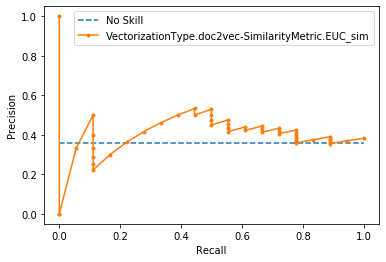

2020-06-10 20:59:33,284 : INFO : Average precision-recall score: 0.43
2020-06-10 20:59:33,289 : INFO : Precision-Recall AUC: 0.398


In [ ]:
supervisedEvalDoc2vec.Compute_avg_precision()

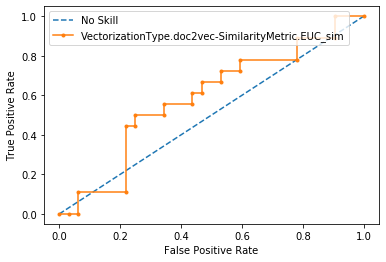

2020-06-10 20:59:37,847 : INFO : ROC AUC 0.587


In [ ]:
supervisedEvalDoc2vec.Compute_roc_curve()

/usr/local/lib/python3.6/dist-packages/prg/prg.py:271: RuntimeWarning: invalid value encountered in double_scalars
  return (a[0] - o[0]) * (b[1] - o[1]) - (a[1] - o[1]) * (b[0] - o[0])


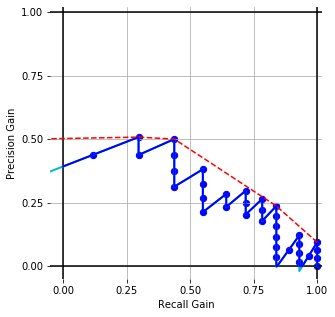

2020-06-10 20:59:43,655 : INFO : auprg:  0.316
2020-06-10 20:59:43,656 : INFO : compute_precision_recall_gain Complete


In [ ]:
supervisedEvalDoc2vec.Compute_precision_recall_gain()

## Compute distribution of similarities doc2vec

In [ ]:
#Basic Statistics
filter_doc2vec = doc2vec.df_ground_link
filter_doc2vec.describe()

,DistanceMetric.EUC,SimilarityMetric.EUC_sim,Linked?
count,50.000000,50.000000,50.000000
mean,32.555240,0.031372,0.360000
std,7.090463,0.007993,0.484873
min,16.162106,0.021626,0.000000
25%,27.673811,0.026095,0.000000
50%,32.481735,0.029868,0.000000
75%,37.322314,0.034877,1.000000
max,45.240738,0.058268,1.000000


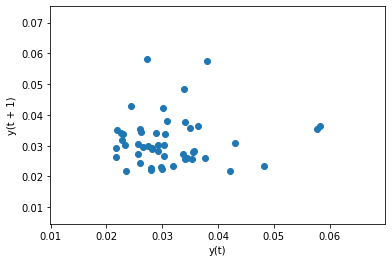

In [ ]:
lag_plot(filter_doc2vec[[SimilarityMetric.EUC_sim]])

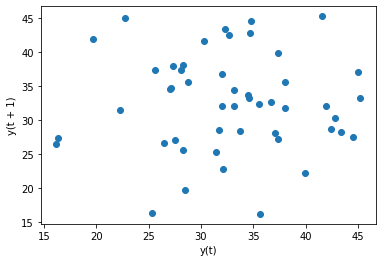

In [ ]:
lag_plot(filter_doc2vec[DistanceMetric.EUC])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f33c61aa1d0>,
      dtype=object)

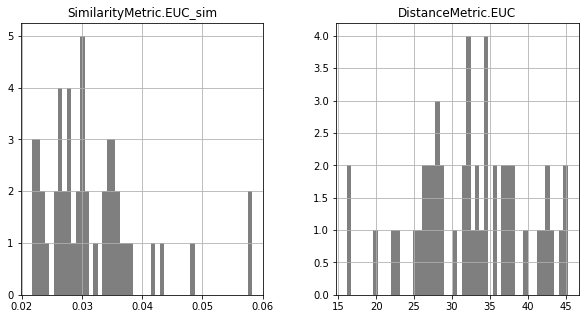

In [ ]:
filter_doc2vec.hist(column=[SimilarityMetric.EUC_sim,DistanceMetric.EUC],color='k',bins=50,figsize=[10,5],alpha=0.5)

SimilarityMetric.EUC_sim    0.007993
DistanceMetric.EUC          7.090463
dtype: float64


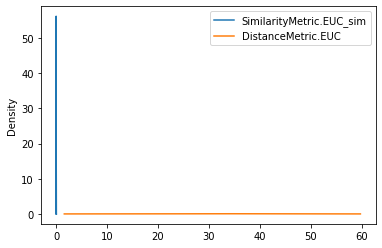

In [ ]:
#Separate distance from similarity analysis here
errors = filter_doc2vec[[SimilarityMetric.EUC_sim,DistanceMetric.EUC]].std()
print(errors)
filter_doc2vec[[SimilarityMetric.EUC_sim,DistanceMetric.EUC]].plot.kde()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f33c5833ba8>,
      dtype=object)

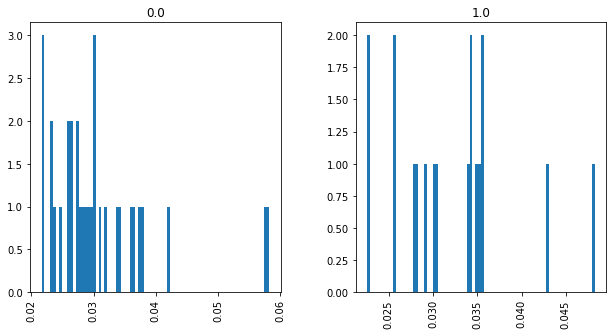

In [ ]:
filter_doc2vec.hist(by='Linked?',column=SimilarityMetric.EUC_sim,figsize=[10, 5],bins=80)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f33c37f8be0>,
      dtype=object)

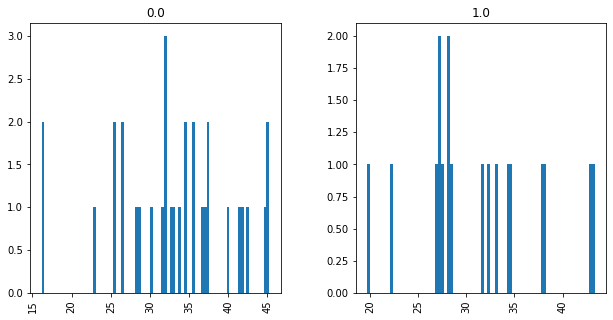

In [ ]:
filter_doc2vec.hist(by='Linked?',column=DistanceMetric.EUC,figsize=[10, 5],bins=80)

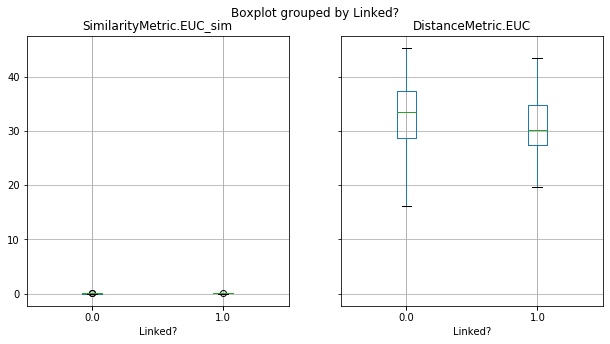

In [ ]:
#separate the distance from the similarity plot
boxplot = filter_doc2vec.boxplot(by='Linked?',column=[SimilarityMetric.EUC_sim,DistanceMetric.EUC],figsize=[10, 5])

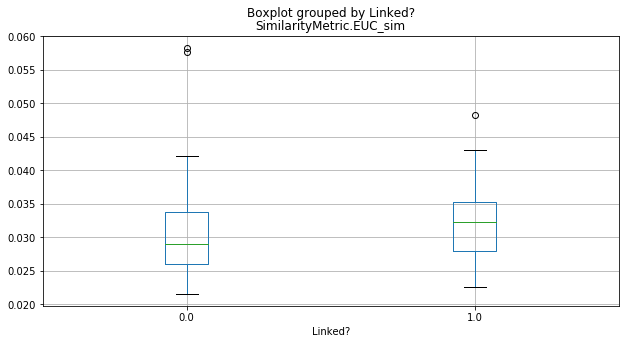

In [ ]:
boxplot = filter_doc2vec.boxplot(by='Linked?',column=[SimilarityMetric.EUC_sim],figsize=[10, 5])

## Combining Doc2vec and Word2vec
Please check this post for futher detatils [link](https://stats.stackexchange.com/questions/217614/intepreting-doc2vec-cosine-similarity-between-doc-vectors-and-word-vectors)

In [ ]:
! nbdev_build_docs #<-------- [Activate when stable]